In [3]:
import numpy as np 
from math import pi
import sympy as sy
import matplotlib.pyplot as plt 
from numba import jit
from sklearn.model_selection import train_test_split

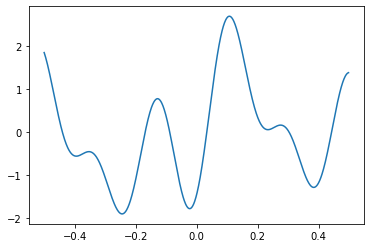

In [4]:
# general random sample 

seed = 2022
np.random.seed(seed)

N_train = 512
x_train = np.random.uniform(-pi,pi,2*N_train)
x_train.sort()
b1,b2,b3 = np.random.uniform(0,2*pi,3)
y_train = np.sin(x_train) + np.sin(10*x_train+b1) + np.sin(20*x_train+b2) + np.sin(30*x_train+b3)

# split the data 
# x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.5)
# print(len(x_tr))
# x_ts, y_ts = zip(*sorted(zip(x_ts, y_ts)))

# grid sample
N_sb = 1000
dx = 0.001
x_sb = np.linspace(-N_sb/2*dx, (N_sb/2-1)*dx, N_sb, endpoint=False)
x_sb.sort()
y_sb = np.sin(x_sb) + np.sin(10*x_sb+b1) + np.sin(20*x_sb+b2) + np.sin(30*x_sb+b3)

# plt.plot(x_ts,y_ts)
# plt.show()
plt.plot(x_sb, y_sb)
plt.show()

In [15]:
# define fp
d = 1
px = 1/2/pi

fp = np.sqrt(px) * (y_sb - np.mean(y_sb))

# f_mean = np.sum(px * y_sb * dx)
# fp = np.sqrt(px) * (y_sb - f_mean)
# fp = np.reshape(fp, (N_sb,1))
print(np.shape(fp))

(1000,)


In [16]:
# define the function includes w0

@jit(nopython=True)
def f_approx(w0):
    f = 0
    for i in range(N_sb-1):
        for j in range(N_sb-1): 
            sinc = 1
            if d == 1: 
                K = [1]
            else: 
                K = range(1,d)
            for k in K: 
                t = w0*(x_sb[j]**k - x_sb[i]**k)
                if t == 0: 
                    sinc = sinc * 1
                else: 
                    sinc = sinc * np.sin(t) / t
            f = f + fp[i]*fp[j]/(px*px) * (w0/pi)**d * sinc 
    f = f * 2 / (N_sb**2)
    return f      

# print(f_approx(10))

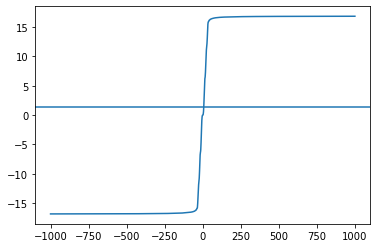

In [17]:
W = np.linspace(-N_sb, N_sb, 2*N_sb+1)
# print(W)
f_w = np.zeros(2*N_sb+1)

for w in W: 
    i = w + N_sb
    i = int(i)
    f_w[i] = f_approx(w)
# print(f_w)

y_var = np.var(y_sb)
# print(y_var)

plt.plot(W, f_w)
plt.axhline(y = y_var)
plt.show()

In [18]:
# compute the cut-off w0

# w0 = sy.symbols('w0')
# print(sy.solve(f_approx(w0)-np.var(y),w0))

f_abs = np.abs(f_w-y_var)

f_min = min(f_abs)
print(f_min)

w0 = np.argmin(f_abs) - N_sb
print(w0)

0.14683794911248094
7


In [19]:
# training the function with NN  

import tensorflow as tf 
from tensorflow import keras 

In [20]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, hidden_layer_1,
                          hidden_layer_2, hidden_layer_3, 
                          hidden_layer_4, hidden_layer_5, 
                          output_layer])

# compling the model 
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = 'adam', loss = 'mse')

In [21]:
def SB_epoch(n_epoch):
    # fitting the data 
    tf.random.set_seed(seed)
    beta = model.fit(x_train, y_train, epochs=n_epoch, batch_size=32)

    # predicting the data
    predict_1 = model.predict(x_sb)

    # compute r
    predict_1 = predict_1.reshape(N_sb)
    r = y_sb - predict_1

    plt.plot(x_sb, y_sb, color='black')
    plt.plot(x_sb, predict_1, color='g')
    plt.plot(x_sb, r, color='r')
    plt.show()


    # calculate r_p
    px = 1/2/pi
    rp = np.sqrt(px) * (r - np.mean(r))

    # compute sum_low

    e_low = 0
    for i in range(N_sb-1):
        for j in range(N_sb-1): 
            sinc = 1
            if d == 1: 
                K = [1]
            else: 
                K = range(1,d)
            for k in K: 
                t = w0*(x_sb[j]**k - x_sb[i]**k)
                if t == 0: 
                    sinc = sinc * 1
                else: 
                    sinc = sinc * np.sin(t) / t
            e_low = e_low + rp[i]*rp[j]/px/px * (w0 **d / pi**d) * sinc 
    e_low = e_low / (N_sb**2) / y_var
    print(e_low)

    # compute SB
    var_r = np.var(r)
    var_f = np.var(y_sb)
    FVU = var_r/var_f 
    print(FVU)
    SB = (FVU-2*e_low)/FVU
    print(SB)

Epoch 1/20
32/32 [==============================] - 1s 934us/step - loss: 2.0789
Epoch 2/20
32/32 [==============================] - 0s 975us/step - loss: 2.0212
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 2.0477
Epoch 4/20
32/32 [==============================] - 0s 954us/step - loss: 2.0083
Epoch 5/20
32/32 [==============================] - 0s 932us/step - loss: 2.0031
Epoch 6/20
32/32 [==============================] - 0s 986us/step - loss: 1.9422
Epoch 7/20
32/32 [==============================] - 0s 2ms/step - loss: 1.8615
Epoch 8/20
32/32 [==============================] - 0s 988us/step - loss: 1.7101
Epoch 9/20
32/32 [==============================] - 0s 2ms/step - loss: 1.6891
Epoch 10/20
32/32 [==============================] - 0s 1ms/step - loss: 1.6852
Epoch 11/20
32/32 [==============================] - 0s 2ms/step - loss: 1.6876
Epoch 12/20
32/32 [==============================] - 0s 959us/step - loss: 1.6866
Epoch 13/20
32/32 [================

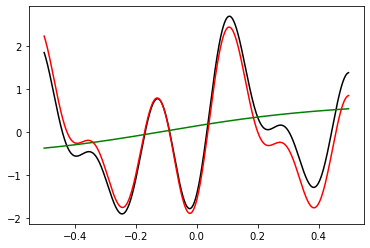

0.10635009147642781
0.9613538012861541
0.7787493192742431
Epoch 1/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6555
Epoch 2/100
32/32 [==============================] - 0s 943us/step - loss: 1.6523
Epoch 3/100
32/32 [==============================] - 0s 944us/step - loss: 1.6760
Epoch 4/100
32/32 [==============================] - 0s 830us/step - loss: 1.6496
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 1.6566
Epoch 6/100
32/32 [==============================] - 0s 988us/step - loss: 1.6507
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 1.6605
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6446
Epoch 9/100
32/32 [==============================] - 0s 849us/step - loss: 1.6480
Epoch 10/100
32/32 [==============================] - 0s 929us/step - loss: 1.6480
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 1.6567
Epoch 12/100
32/32 [============================

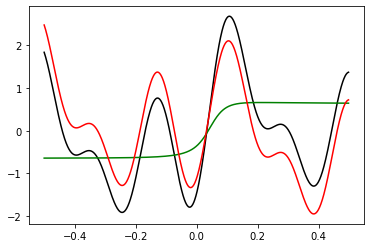

0.32349509998476883
0.8595782964740531
0.2473167335384585
Epoch 1/500
32/32 [==============================] - 0s 660us/step - loss: 1.6221
Epoch 2/500
32/32 [==============================] - 0s 638us/step - loss: 1.6157
Epoch 3/500
32/32 [==============================] - 0s 698us/step - loss: 1.6272
Epoch 4/500
32/32 [==============================] - 0s 702us/step - loss: 1.6113
Epoch 5/500
32/32 [==============================] - 0s 680us/step - loss: 1.6210
Epoch 6/500
32/32 [==============================] - 0s 677us/step - loss: 1.6148
Epoch 7/500
32/32 [==============================] - 0s 720us/step - loss: 1.6230
Epoch 8/500
32/32 [==============================] - 0s 722us/step - loss: 1.6158
Epoch 9/500
32/32 [==============================] - 0s 692us/step - loss: 1.6149
Epoch 10/500
32/32 [==============================] - 0s 739us/step - loss: 1.6095
Epoch 11/500
32/32 [==============================] - 0s 714us/step - loss: 1.6202
Epoch 12/500
32/32 [==================

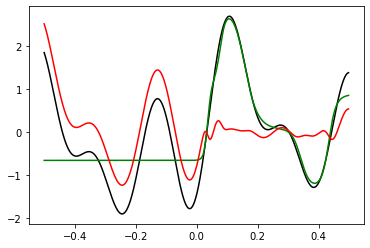

0.0944778898134696
0.34476787175488516
0.45193332932925234
Epoch 1/1000
32/32 [==============================] - 0s 739us/step - loss: 1.5296
Epoch 2/1000
32/32 [==============================] - 0s 682us/step - loss: 1.5311
Epoch 3/1000
32/32 [==============================] - 0s 739us/step - loss: 1.5394
Epoch 4/1000
32/32 [==============================] - 0s 720us/step - loss: 1.5279
Epoch 5/1000
32/32 [==============================] - 0s 682us/step - loss: 1.5312
Epoch 6/1000
32/32 [==============================] - 0s 684us/step - loss: 1.5306
Epoch 7/1000
32/32 [==============================] - 0s 703us/step - loss: 1.5382
Epoch 8/1000
32/32 [==============================] - 0s 690us/step - loss: 1.5325
Epoch 9/1000
32/32 [==============================] - 0s 748us/step - loss: 1.5312
Epoch 10/1000
32/32 [==============================] - 0s 695us/step - loss: 1.5301
Epoch 11/1000
32/32 [==============================] - 0s 697us/step - loss: 1.5422
Epoch 12/1000
32/32 [=====

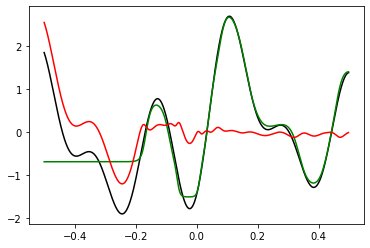

0.08764357788138111
0.21417537596391004
0.18157185449601237
Epoch 1/2000
32/32 [==============================] - 0s 762us/step - loss: 1.4145
Epoch 2/2000
32/32 [==============================] - 0s 712us/step - loss: 1.4110
Epoch 3/2000
32/32 [==============================] - 0s 775us/step - loss: 1.4173
Epoch 4/2000
32/32 [==============================] - 0s 766us/step - loss: 1.4103
Epoch 5/2000
32/32 [==============================] - 0s 897us/step - loss: 1.4132
Epoch 6/2000
32/32 [==============================] - 0s 790us/step - loss: 1.4124
Epoch 7/2000
32/32 [==============================] - 0s 780us/step - loss: 1.4217
Epoch 8/2000
32/32 [==============================] - 0s 812us/step - loss: 1.4145
Epoch 9/2000
32/32 [==============================] - 0s 798us/step - loss: 1.4122
Epoch 10/2000
32/32 [==============================] - 0s 843us/step - loss: 1.4151
Epoch 11/2000
32/32 [==============================] - 0s 708us/step - loss: 1.4210
Epoch 12/2000
32/32 [====

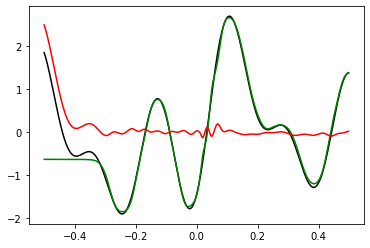

0.1377237167838031
0.12587923758062772
-1.188187971754894
Epoch 1/3000
32/32 [==============================] - 0s 732us/step - loss: 1.3735
Epoch 2/3000
32/32 [==============================] - 0s 689us/step - loss: 1.3735
Epoch 3/3000
32/32 [==============================] - 0s 668us/step - loss: 1.3752
Epoch 4/3000
32/32 [==============================] - 0s 735us/step - loss: 1.3730
Epoch 5/3000
32/32 [==============================] - 0s 731us/step - loss: 1.3740
Epoch 6/3000
32/32 [==============================] - 0s 777us/step - loss: 1.3745
Epoch 7/3000
32/32 [==============================] - 0s 704us/step - loss: 1.3792
Epoch 8/3000
32/32 [==============================] - 0s 679us/step - loss: 1.3793
Epoch 9/3000
32/32 [==============================] - 0s 690us/step - loss: 1.3744
Epoch 10/3000
32/32 [==============================] - 0s 707us/step - loss: 1.3766
Epoch 11/3000
32/32 [==============================] - 0s 695us/step - loss: 1.3751
Epoch 12/3000
32/32 [======

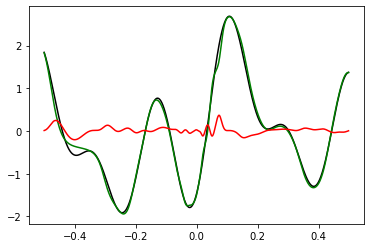

0.0001107829800512808
0.0057672949160364915
0.9615823426184644
Epoch 1/4000
32/32 [==============================] - 0s 807us/step - loss: 1.1642
Epoch 2/4000
32/32 [==============================] - 0s 809us/step - loss: 1.1577
Epoch 3/4000
32/32 [==============================] - 0s 846us/step - loss: 1.1545
Epoch 4/4000
32/32 [==============================] - 0s 775us/step - loss: 1.1432
Epoch 5/4000
32/32 [==============================] - 0s 833us/step - loss: 1.1479
Epoch 6/4000
32/32 [==============================] - 0s 806us/step - loss: 1.1384
Epoch 7/4000
32/32 [==============================] - 0s 873us/step - loss: 1.1441
Epoch 8/4000
32/32 [==============================] - 0s 789us/step - loss: 1.1366
Epoch 9/4000
32/32 [==============================] - 0s 838us/step - loss: 1.1487
Epoch 10/4000
32/32 [==============================] - 0s 933us/step - loss: 1.1666
Epoch 11/4000
32/32 [==============================] - 0s 974us/step - loss: 1.1851
Epoch 12/4000
32/32 [=

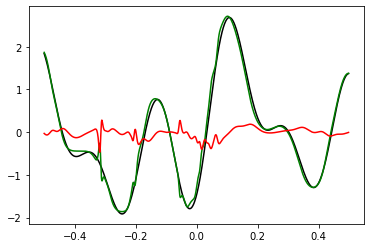

0.003725412473931728
0.01013374937911775
0.26475140946182263


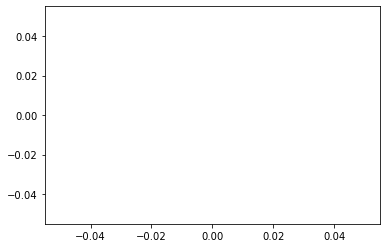

In [22]:
epoch_list = np.array([20, 100, 500, 1000, 2000, 3000, 4000], dtype='int')

i=0
SB_list = np.zeros(7)
for epoch in epoch_list: 
    SB_list[i] = SB_epoch(epoch)
    i = i+1

plt.plot(epoch_list, SB_list)